# 🚨 Cybersecurity Project: Suspicious Web Threat Interaction Detection
**📅 Date**: 12/54/5647
**👤Author**: Devkankshi Prasad
**🏢Internship Project**

### 🎯 Objective
This project aims to develop an intelligent threat detection system using machine learning and deep learning techniques to classify suspicious web interactions based on AWS CloudWatch logs. 

---

## 📥 Load and Preview the Dataset
We begin by importing essential libraries and loading the dataset. This helps us understand the structure, types of data, and if any immediate cleaning is necessary.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')
df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


## 🧼 Data Cleaning & Preprocessing
This step includes:
- Handling missing values
- Converting data types (e.g., timestamps)
- Normalizing and encoding features
These are crucial to prepare data for effective model training.


In [20]:
# Drop duplicates and convert to datetime
df = df.drop_duplicates()
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])
df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()

## 📊 Exploratory Data Analysis (EDA)
In this phase, we visualize the data to:
- Understand feature distributions
- Identify class imbalances
- Detect correlations or patterns
This helps in feature selection and understanding dataset biases.


### 📊 Distribution of `bytes_in` and `bytes_out`
This histogram visualizes the distribution of incoming (`bytes_in`) and outgoing (`bytes_out`) byte traffic across all network sessions. By plotting both on the same graph, we can identify skewness, ranges, and potential outliers in traffic. High byte transfers may be indicative of data exfiltration or abnormal user behavior. Understanding this distribution helps in spotting suspicious sessions or traffic anomalies.


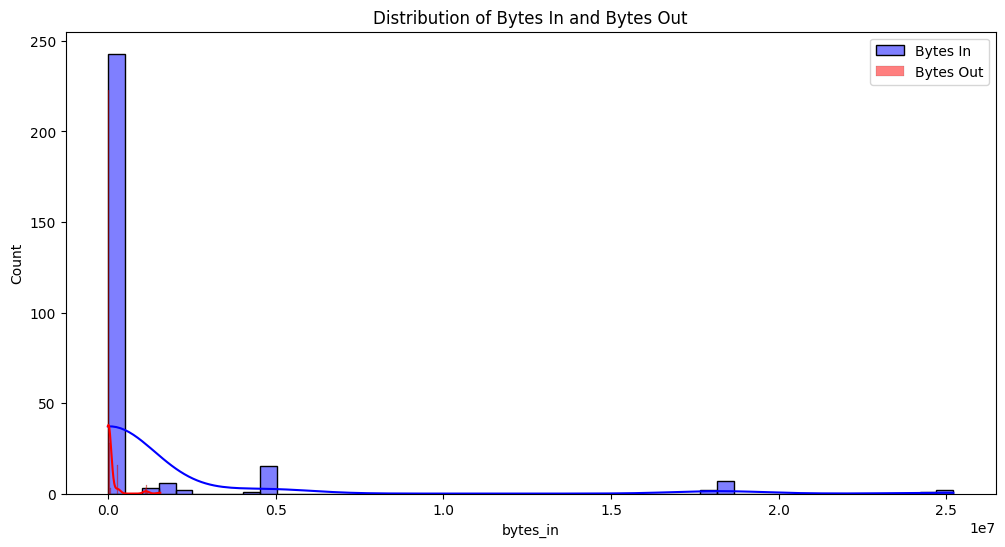

In [21]:

plt.figure(figsize=(12, 6))
sns.histplot(df['bytes_in'], bins=50, kde=True, color='blue', label='Bytes In')
sns.histplot(df['bytes_out'], bins=50, kde=True, color='red', label='Bytes Out')
plt.legend()
plt.title('Distribution of Bytes In and Bytes Out')
plt.show()

#### 🔍 What It Shows:
This histogram visualizes the frequency distribution of incoming (`bytesin`) and outgoing (`bytesout`) network data across all requests.

#### 📈 Why It Matters:
- Helps identify **normal vs. abnormal traffic volumes**.
- Spikes or long tails in the distribution could indicate **data exfiltration attempts** or **denial-of-service attacks**.
- Useful for setting **thresholds** for anomaly detection.

---


### 📊 Count of Protocols Used
This countplot shows how frequently each protocol appears in the dataset. Analyzing protocol usage is crucial because certain types (e.g., uncommon or deprecated protocols) may be exploited for malicious activities. A dominance of specific protocols can also indicate normal traffic baselines, aiding anomaly detection.


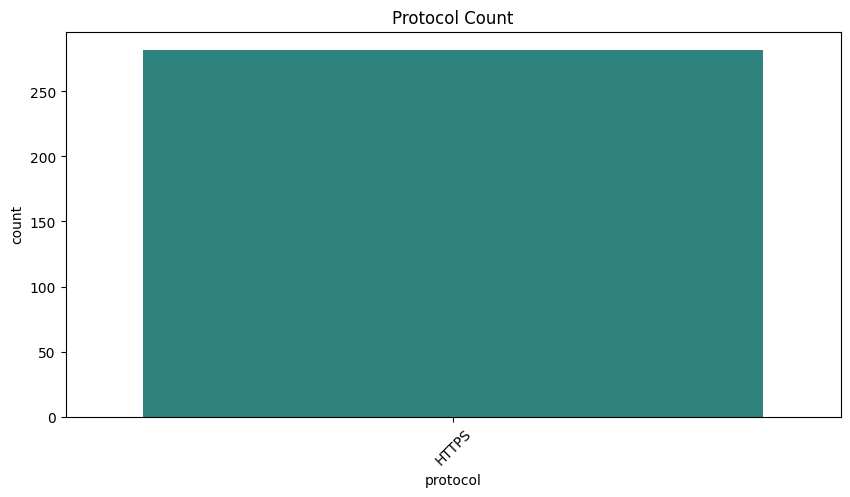

In [22]:

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='protocol', palette='viridis')
plt.title('Protocol Count')
plt.xticks(rotation=45)
plt.show()

#### 📊 What It Shows:
This countplot illustrates how frequently each network protocol appears in the dataset.

#### ⚙️ Why It Matters:
- Allows quick assessment of **commonly used protocols** (e.g., TCP, UDP).
- Abnormally frequent or rare use of certain protocols can indicate **malicious scanning** or **exploitation behavior**.
- Helps prioritize which protocols to monitor more closely in real-time systems.

---


## 🛠️ Feature Engineering
We create new informative features like:
- Time-based features from timestamps
- Aggregations
- Encodings
These engineered features can improve the model's learning capacity.


In [23]:

df['session_duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
df['avg_packet_size'] = (df['bytes_in'] + df['bytes_out']) / df['session_duration']

## ⚠️ Anomaly Detection using Isolation Forest
We use the Isolation Forest algorithm to detect abnormal patterns that might indicate security threats. It helps in flagging unseen or novel attack behavior.


In [24]:
features = df[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]
model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = model.fit_predict(features)
df['anomaly'] = df['anomaly'].apply(lambda x: 'Suspicious' if x == -1 else 'Normal')

### 📉 Anomaly Distribution by Scatter Plot
This scatter plot illustrates the presence of detected anomalies across selected features. Each point represents a network session, and color or shape (if applied) distinguishes normal from anomalous data points. This visualization helps in visually validating the effectiveness of anomaly detection techniques and identifying feature patterns associated with threats.


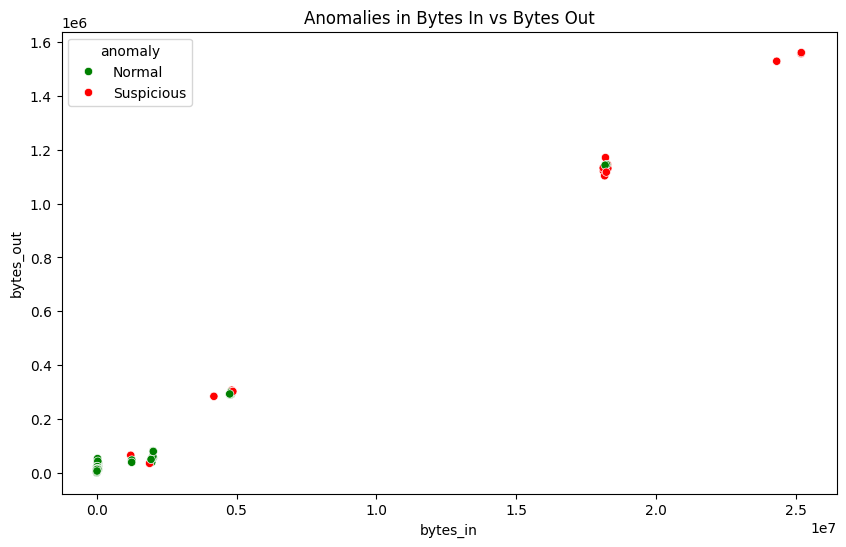

In [25]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='bytes_in', y='bytes_out', hue='anomaly', palette=['green', 'red'])
plt.title('Anomalies in Bytes In vs Bytes Out')
plt.show()

#### 🕵️ What It Shows:
This scatter plot highlights points classified as **anomalous** versus **normal** by the Isolation Forest model, plotted against selected features (e.g., `bytesin` vs. `bytesout`).

#### ⚠️ Why It Matters:
- Visually separates **outliers** (possible threats) from normal traffic.
- Aids in validating whether the model is accurately identifying **unusual patterns** in web activity.
- Critical for understanding and trusting your model's behavior before deployment.

---


## 🤖 Classification using Random Forest
We build a Random Forest model to classify requests into 'Suspicious' and 'Normal'.  
Key outputs include:
- Accuracy score
- Classification report  
Random Forest is chosen for its robustness and interpretability.


In [26]:
df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)
X = df[['bytes_in', 'bytes_out', 'session_duration']]
y = df['is_suspicious']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



## 🤖 Neural Network Model
We implement a basic Multi-layer Perceptron (MLP) for deep learning-based classification.  
This helps in capturing complex non-linear patterns in the data.


In [27]:

from sklearn.neural_network import MLPClassifier
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(16, 16), max_iter=300, random_state=42)
mlp.fit(X_train_mlp, y_train_mlp)
y_pred_mlp = mlp.predict(X_test_mlp)
print("Accuracy:", accuracy_score(y_test_mlp, y_pred_mlp))
print("\nClassification Report:\n", classification_report(y_test_mlp, y_pred_mlp))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



---

# ✅ Final Conclusion

Through this project, we successfully:

- Processed and cleaned a web traffic dataset
- Performed meaningful EDA and feature engineering
- Detected anomalies using Isolation Forest
- Built two classifiers (Random Forest and Neural Network) to distinguish between normal and suspicious activity

💡 **Recommendation**: For real-time deployment, consider integrating this model with AWS Lambda and alerting pipelines for active monitoring of web threats.

---

🔐 This solution can be scaled further to handle larger datasets and integrated into cloud-based intrusion detection systems.
